# varlib demo

## Variable definitions

variables can be defined in a yaml file:

In [1]:
var_yml = """
household:
    - hhsize = household.aggregate(person.person_id > 0)
    - nchildren = household.aggregate(person.is_child)
    - nadults = hhsize - nchildren
    - cars_per_adults = cars / nadults
    - cars_per_adults_gt1 = cars_per_adults > 1.0
    - sqrt_hhsize = 1 + sqrt(hhsize)
    - exp_hhsize = exp(hhsize)

person:
    - is_child = age < 18
    - is_child_int = (age < 18).astype('int')
    - is_child_int2 = (is_child).astype('int')
    - is_girl = is_child and sex == 'F'
    - log1p_age = log(age+1)
    - hh_nadults = person.disaggregate(household.nadults)

zone:
    - nadults = zone.aggregate(household.nadults)
"""

## Variable definition parsing and dependency graph

varlib can load the variable definitions from yaml file, parse them and build a dependency graph solely from the information in the variable definitions. The dependency graph is in networkx directed acyclic graph (DAG) format.

**Visualize the depedency graph**

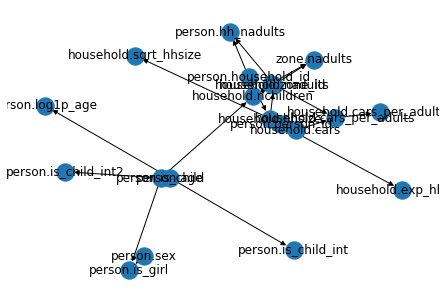

In [5]:
import networkx as nx
from varlib.parse import build_graph
import itertools

dep_graph = build_graph("variables.yml")

nx.draw(dep_graph, with_labels = True)

**Visualize the depedency graph (interactive)**

In [4]:
from pyvis.network import Network
VG = Network(notebook=True)
VG.from_nx(dep_graph)
#VG.enable_physics(True)
VG.show("dep_graph.html")

## Utilizing the dependency graph in variable computation

In [6]:
from varlib.compute import compute
import pandas as pd
import numpy as np
import logging

logging.basicConfig(
    format='%(asctime)s %(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.DEBUG)

pp_data = {'person_id': [1, 2, 3, 4],
        'household_id': [1, 1, 2, 2],
        'age':[2,   26,  39, 10],
        'sex':['F', 'F', 'M', 'M']}
person = pd.DataFrame(pp_data).set_index("person_id")
person.name = "person"

resolvers={'person': person}

person

,household_id,age,sex
person_id,,,
1,1,2,F
2,1,26,F
3,2,39,M
4,2,10,M


In [7]:
compute(["person.is_girl", 'person.log1p_age'], dep_graph, resolvers=resolvers)

2019-11-29 13:33:47 INFO: Computing person.is_girl started ...
2019-11-29 13:33:47 INFO:   Computing person.is_child started ...
2019-11-29 13:33:47 INFO:     Computing person.age started ...
2019-11-29 13:33:47 INFO:       Computing person.age skipped
2019-11-29 13:33:47 INFO:     Computing person.age done in 0.00s.
2019-11-29 13:33:47 INFO:     Computing person.is_child (new variable)
2019-11-29 13:33:47 INFO:   Computing person.is_child done in 0.01s.
2019-11-29 13:33:47 INFO:   Computing person.sex started ...
2019-11-29 13:33:47 INFO:     Computing person.sex skipped
2019-11-29 13:33:47 INFO:   Computing person.sex done in 0.00s.
2019-11-29 13:33:47 INFO:   Computing person.is_girl (new variable)
2019-11-29 13:33:47 INFO: Computing person.is_girl done in 0.02s.
2019-11-29 13:33:47 INFO: Computing person.log1p_age started ...
2019-11-29 13:33:47 INFO:   Computing person.age started ...
2019-11-29 13:33:47 INFO:     Computing person.age skipped
2019-11-29 13:33:47 INFO:   Computing 

In [8]:
person

,household_id,age,sex,is_child,is_girl,log1p_age
person_id,,,,,,
1,1,2,F,True,True,1.098612
2,1,26,F,False,False,3.295837
3,2,39,M,False,False,3.688879
4,2,10,M,True,False,2.397895


## Lazy recompute

In [9]:
col1 = person['is_girl']
# since is_girl has been computed and its dependencies haven't changed
# nothing should happen if we call compute again
compute("person.is_girl", dep_graph, resolvers=resolvers)
# and the series should be the same as before
assert id(person['is_girl']) == id(col1), "lazy recompute not enabled"


2019-11-29 13:33:55 INFO: Computing person.is_girl started ...
2019-11-29 13:33:55 INFO:   Computing person.is_child started ...
2019-11-29 13:33:55 INFO:     Computing person.age started ...
2019-11-29 13:33:55 INFO:       Computing person.age skipped
2019-11-29 13:33:55 INFO:     Computing person.age done in 0.00s.
2019-11-29 13:33:55 INFO:     Computing person.is_child skipped
2019-11-29 13:33:55 INFO:   Computing person.is_child done in 0.01s.
2019-11-29 13:33:55 INFO:   Computing person.sex started ...
2019-11-29 13:33:55 INFO:     Computing person.sex skipped
2019-11-29 13:33:55 INFO:   Computing person.sex done in 0.00s.
2019-11-29 13:33:55 INFO:   Computing person.is_girl skipped
2019-11-29 13:33:55 INFO: Computing person.is_girl done in 0.01s.


In [11]:
# if we change age, then is_girl will be recomputed if we call compute again
person['age'] += 10
compute("person.is_girl", dep_graph, resolvers=resolvers)
assert id(person['is_girl']) != id(col1), "failed to recompute when deps change"

2019-11-29 13:34:17 INFO: Computing person.is_girl started ...
2019-11-29 13:34:17 INFO:   Computing person.is_child started ...
2019-11-29 13:34:17 INFO:     Computing person.age started ...
2019-11-29 13:34:17 INFO:       Computing person.age skipped
2019-11-29 13:34:17 INFO:     Computing person.age done in 0.00s.
2019-11-29 13:34:17 INFO:     Computing person.is_child (dependency updated)
2019-11-29 13:34:17 INFO:   Computing person.is_child done in 0.01s.
2019-11-29 13:34:17 INFO:   Computing person.sex started ...
2019-11-29 13:34:17 INFO:     Computing person.sex skipped
2019-11-29 13:34:17 INFO:   Computing person.sex done in 0.00s.
2019-11-29 13:34:17 INFO:   Computing person.is_girl (dependency updated)
2019-11-29 13:34:17 INFO: Computing person.is_girl done in 0.02s.


In [12]:
# or recomputing can be foreced
col2 = person['is_girl']
compute("person.is_girl", dep_graph, resolvers=resolvers, recompute=True)
assert id(person['is_girl']) != id(col2), "force recompute failed"


2019-11-29 13:34:21 INFO: Computing person.is_girl started ...
2019-11-29 13:34:21 INFO:   Computing person.is_child started ...
2019-11-29 13:34:21 INFO:     Computing person.age started ...
2019-11-29 13:34:21 INFO:       Computing person.age skipped
2019-11-29 13:34:21 INFO:     Computing person.age done in 0.00s.
2019-11-29 13:34:21 INFO:     Computing person.is_child skipped
2019-11-29 13:34:21 INFO:   Computing person.is_child done in 0.01s.
2019-11-29 13:34:21 INFO:   Computing person.sex started ...
2019-11-29 13:34:21 INFO:     Computing person.sex skipped
2019-11-29 13:34:21 INFO:   Computing person.sex done in 0.00s.
2019-11-29 13:34:21 INFO:   Computing person.is_girl (forced recomputing)
2019-11-29 13:34:21 INFO: Computing person.is_girl done in 0.02s.


## TODO
- [ ] feedback? 
   - Is it useful?
- [ ] a simpler parser for parsing common expressions to be evaluated, e.g. (none of them work yet)
   * person.eval("pd.to_numeric(age<18)")
   * person.eval("(age<18).astype('int')")
   * pd.eval("(person.age).astype('int')")
   - [ ] find references of data frame columns in an expression and replace them with Series from the resolvers
   - [ ] does this approach disable the numexpr engine?
   - [ ] how much advantage does the numexpr engine provide? (1-4x)
- [ ] are there other common patterns of variable definitions that need to support?
- [ ] a variable checker that verifies variable definitions
- [ ] is there a need to specify dataset relationship? If yes, what is the most sensible way to do so?